1. Establish an auto-encoder Architecture then train your model on MINST Dataset (Specify the
best hyper-parameters)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), np.prod(x_train.shape[1:])))
x_test = np.reshape(x_test, (len(x_test), np.prod(x_test.shape[1:])))

In [4]:
input_dim = 784
encoding_dim = 32

# Architecture de l'auto-encodeur
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

In [5]:
autoencoder = Model(input_img, decoded)

# Compilation du modèle
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Entraînement du modèle
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# Obtention des sorties encodées
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

# Obtention des sorties décodées
decoded_imgs = autoencoder.predict(x_test)

Epoch 1/50
235/235 [==============================] - 3s 11ms/step - loss: 0.2770 - val_loss: 0.1894
Epoch 2/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1710 - val_loss: 0.1538
Epoch 3/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1445 - val_loss: 0.1337
Epoch 4/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1283 - val_loss: 0.1208
Epoch 5/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1178 - val_loss: 0.1124
Epoch 6/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1107 - val_loss: 0.1066
Epoch 7/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1056 - val_loss: 0.1022
Epoch 8/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1019 - val_loss: 0.0992
Epoch 9/50
235/235 [==============================] - 3s 11ms/step - loss: 0.0992 - val_loss: 0.0968
Epoch 10/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0974 - val_loss: 0.0

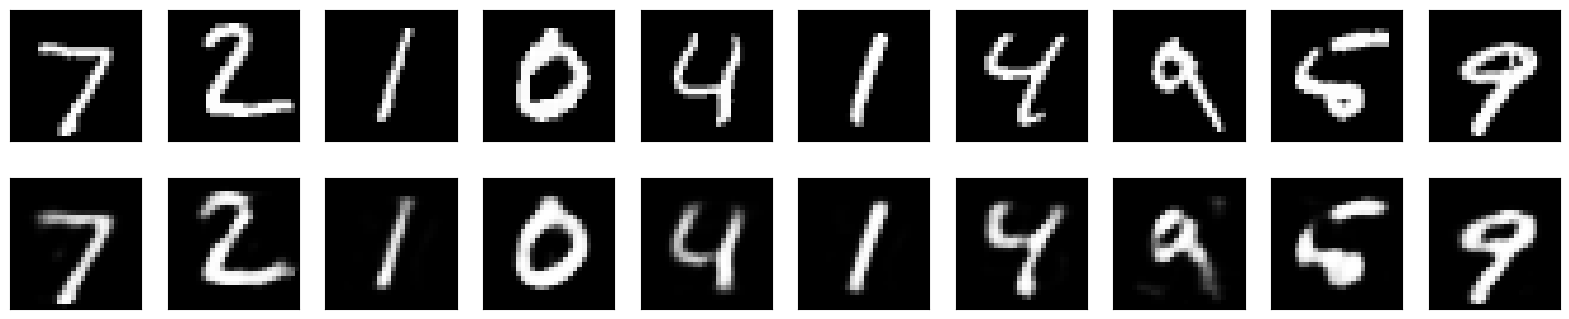

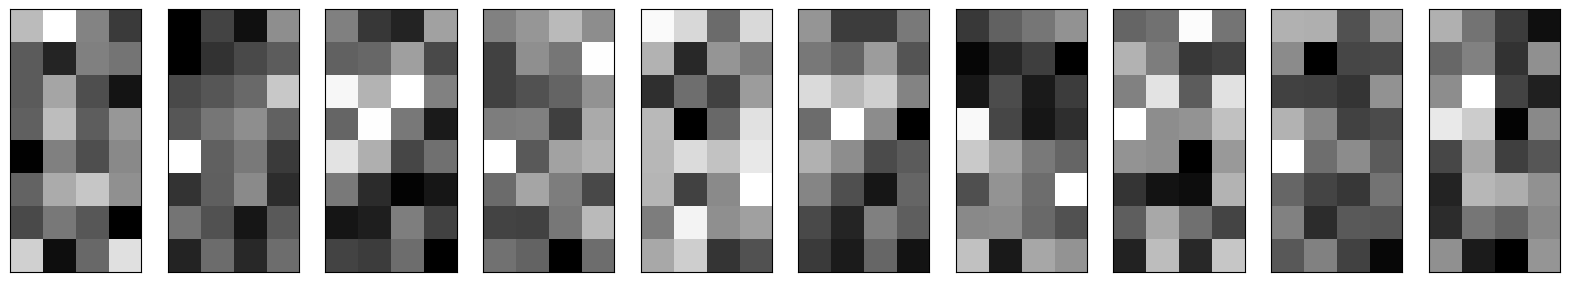

In [6]:
import matplotlib.pyplot as plt

# Afficher quelques exemples d'images d'entrée et leurs décodages correspondants
n = 10  # Nombre d'images à afficher
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image d'entrée
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Afficher l'image décodée
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Afficher quelques exemples de représentations encodées
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(8, 4))  # La dimension 8x4 est dérivée de la dimension d'encodage (32)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


2. Establish an Variational auto-encoder Architecture then train your model on MINST Dataset
(Specify the best hyper-parameters)

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Charger les données MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normaliser les données
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), np.prod(x_train.shape[1:])))
x_test = np.reshape(x_test, (len(x_test), np.prod(x_test.shape[1:])))

# Paramètres de l'auto-encodeur variationnel
input_dim = 784  # Taille de l'image MNIST
hidden_dim = 512  # Dimension de la couche cachée
latent_dim = 2  # Dimension de l'espace latent

# Architecture de l'encodeur
input_img = Input(shape=(input_dim,))
hidden = Dense(hidden_dim, activation='relu')(input_img)
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# Échantillonnage dans l'espace latent
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Architecture du décodeur
decoder_hidden = Dense(hidden_dim, activation='relu')
decoder_output = Dense(input_dim, activation='sigmoid')
decoder_input = Input(shape=(latent_dim,))
decoded = decoder_output(decoder_hidden(decoder_input))


encoder = Model(input_img, z)
decoder = Model(decoder_input, decoded)


vae_output = decoder(encoder(input_img))
vae = Model(input_img, vae_output)

# Fonction de perte
reconstruction_loss = binary_crossentropy(input_img, vae_output)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

# Compilation du modèle avec la perte VAE
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Entraînement du modèle
vae.fit(x_train,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, None))

Epoch 1/50
469/469 [==============================] - 14s 28ms/step - loss: 199.0249 - val_loss: 173.3563
Epoch 2/50
469/469 [==============================] - 11s 24ms/step - loss: 170.3066 - val_loss: 167.2420
Epoch 3/50
469/469 [==============================] - 14s 30ms/step - loss: 165.6363 - val_loss: 164.0384
Epoch 4/50
469/469 [==============================] - 12s 26ms/step - loss: 162.9716 - val_loss: 162.3324
Epoch 5/50
469/469 [==============================] - 12s 25ms/step - loss: 160.9721 - val_loss: 160.0713
Epoch 6/50
469/469 [==============================] - 11s 24ms/step - loss: 159.3674 - val_loss: 158.7985
Epoch 7/50
469/469 [==============================] - 11s 24ms/step - loss: 158.0389 - val_loss: 157.8265
Epoch 8/50
469/469 [==============================] - 11s 24ms/step - loss: 156.8850 - val_loss: 156.9142
Epoch 9/50
469/469 [==============================] - 11s 23ms/step - loss: 155.9095 - val_loss: 155.9345
Epoch 10/50
469/469 [=========================

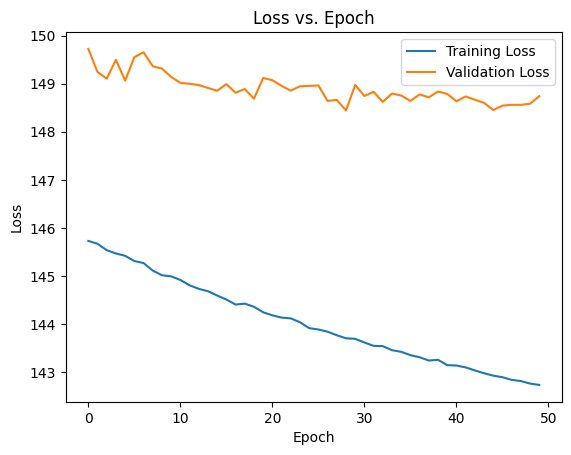

KeyError: 'kl_loss'

In [9]:
import matplotlib.pyplot as plt

# Fonction pour afficher les courbes de perte et de divergence KL
def plot_losses(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.show()

def plot_kl_divergence(history):
    plt.plot(history.history['kl_loss'], label='KL Divergence')
    plt.xlabel('Epoch')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence vs. Epoch')
    plt.legend()
    plt.show()

# Fonction pour afficher quelques exemples d'images d'entrée et décodées
def plot_reconstructed_images(x_test, decoded_imgs):
    n = 10  # Nombre d'images à afficher
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Afficher l'image d'entrée
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Afficher l'image décodée
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Évaluer le modèle VAE
vae_history = vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None), verbose=0)

# Tracer les courbes de perte et de divergence KL
plot_losses(vae_history)
plot_kl_divergence(vae_history)

# Reconstruire les images et les afficher
decoded_imgs_vae = vae.predict(x_test)
plot_reconstructed_images(x_test, decoded_imgs_vae)


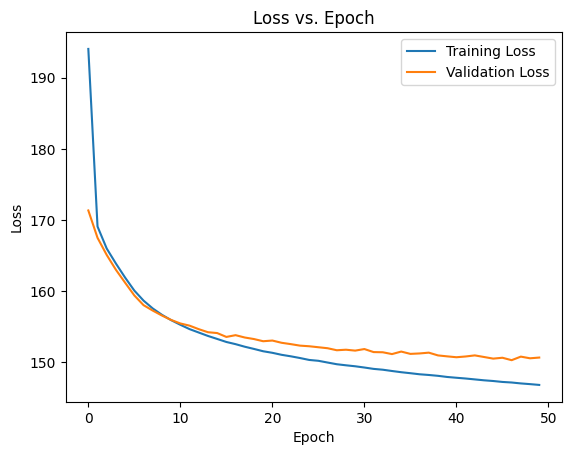

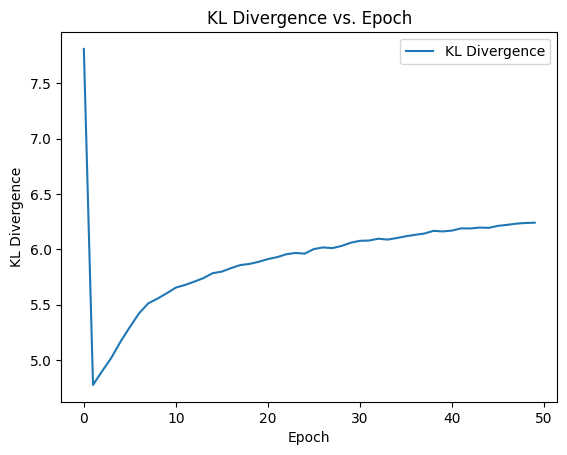

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Fonction pour échantillonner des points de la distribution normale
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Fonction pour afficher les courbes de perte et de divergence KL
def plot_losses(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.show()

def plot_kl_divergence(history):
    plt.plot(history.history['kl_loss'], label='KL Divergence')
    plt.xlabel('Epoch')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence vs. Epoch')
    plt.legend()
    plt.show()

# Charger les données MNIST
(x_train, _), (x_test, _) = mnist.load_data()

# Normaliser les données
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), np.prod(x_train.shape[1:])))
x_test = np.reshape(x_test, (len(x_test), np.prod(x_test.shape[1:])))

# Paramètres de l'auto-encodeur variationnel
input_dim = 784  # Taille de l'image MNIST
hidden_dim = 512  # Dimension de la couche cachée
latent_dim = 2  # Dimension de l'espace latent

# Architecture de l'encodeur
input_img = Input(shape=(input_dim,))
hidden = Dense(hidden_dim, activation='relu')(input_img)
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# Échantillonnage dans l'espace latent
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Architecture du décodeur
decoder_hidden = Dense(hidden_dim, activation='relu')
decoder_output = Dense(input_dim, activation='sigmoid')
decoder_input = Input(shape=(latent_dim,))
decoded = decoder_output(decoder_hidden(decoder_input))

# Modèles de l'encodeur et du décodeur
encoder = Model(input_img, z)
decoder = Model(decoder_input, decoded)

# Modèle complet de l'auto-encodeur variationnel
vae_output = decoder(encoder(input_img))
vae = Model(input_img, vae_output)

# Fonction de perte
reconstruction_loss = binary_crossentropy(input_img, vae_output)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# Enregistrer la perte de divergence KL dans l'historique d'entraînement
vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')

vae_loss = K.mean(reconstruction_loss + kl_loss)

# Compilation du modèle avec la perte VAE
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Entraînement du modèle
vae_history = vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None), verbose=0)

# Tracer les courbes de perte et de divergence KL
plot_losses(vae_history)
plot_kl_divergence(vae_history)


4. Try to plot the latent space of the two models

313/313 [==============================] - 1s 2ms/step


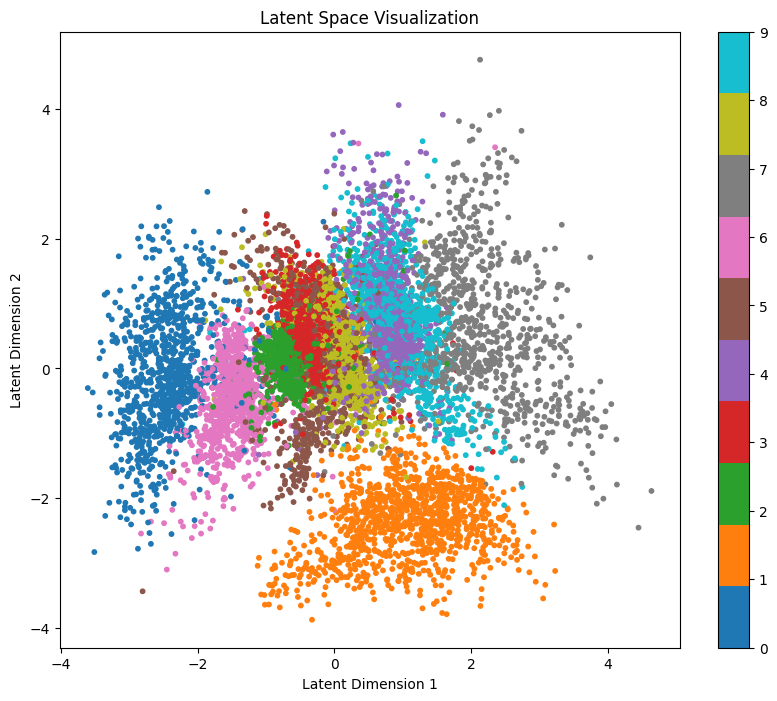

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_latent_space(encoder, x_test, y_test):
    latent_representation = encoder.predict(x_test)

    # Réduire la dimensionnalité de l'espace latent à 2 dimensions
    latent_representation_2d = PCA(n_components=2).fit_transform(latent_representation)

    plt.figure(figsize=(10, 8))
    plt.scatter(latent_representation_2d[:, 0], latent_representation_2d[:, 1], c=y_test, cmap='tab10', s=10)
    plt.colorbar()
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization')
    plt.show()

# Visualiser l'espace latent du modèle VAE
plot_latent_space(encoder, x_test, y_test)
